# TP Simulation de File d'Attente M/M/1 avec SimPy

Ce notebook simule une file d’attente M/M/1 en utilisant Python et SimPy.
Les objectifs sont de :
- Simuler **au moins 1 000 000** de clients par expérience
- Faire varier le taux d’arrivée λ de 0.1 à 0.9
- Répéter chaque expérience pour obtenir des résultats stables
- Calculer :
  - Le **temps de réponse moyen**
  - Le **temps d’attente moyen**
  - Le **taux d’occupation** du serveur (ρ = λ / μ)


In [3]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Constantes globales
MU = 1.0  # Taux de service (μ = 1)
NUM_CLIENTS = 1000000  # Nombre de clients simulés
REPEATS = 5  # Nombre de répétitions pour chaque valeur de λ
LAMBDA_VALUES = np.arange(0.1, 1.0, 0.1)

# Stockage des résultats
results = {
    'lambda': [],
    'response_times': [],
    'waiting_times': [],
    'utilization': []
}

class MM1Queue:
    def __init__(self, env, arrival_rate, service_rate):
        self.env = env
        self.server = simpy.Resource(env, capacity=1)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.wait_times = []
        self.arrival_times = []
        self.response_times = []
        self.busy_time = 0
        self.client_count = 0

    def arrival_process(self):
        while self.client_count < NUM_CLIENTS:
            inter_arrival = random.expovariate(self.arrival_rate)
            yield self.env.timeout(inter_arrival)
            self.client_count += 1
            self.arrival_times.append(self.env.now)
            self.env.process(self.service_process())

    def service_process(self):
        arrival_time = self.env.now
        with self.server.request() as req:
            yield req
            wait = self.env.now - arrival_time
            self.wait_times.append(wait)

            service_time = random.expovariate(self.service_rate)
            self.busy_time += service_time
            yield self.env.timeout(service_time)

            response_time = self.env.now - arrival_time
            self.response_times.append(response_time)

# Exécution des expériences
for LAMBDA in LAMBDA_VALUES:
    rep_response = []
    rep_waiting = []
    rep_util = []

    for _ in range(REPEATS):
        random.seed()  # Initialise une nouvelle graine aléatoire
        env = simpy.Environment()
        queue = MM1Queue(env, arrival_rate=LAMBDA, service_rate=MU)
        env.process(queue.arrival_process())
        env.run()

        rep_response.append(np.mean(queue.response_times))
        rep_waiting.append(np.mean(queue.wait_times))
        rep_util.append(queue.busy_time / queue.env.now)

    results['lambda'].append(LAMBDA)
    results['response_times'].append(np.mean(rep_response))
    results['waiting_times'].append(np.mean(rep_waiting))
    results['utilization'].append(np.mean(rep_util))


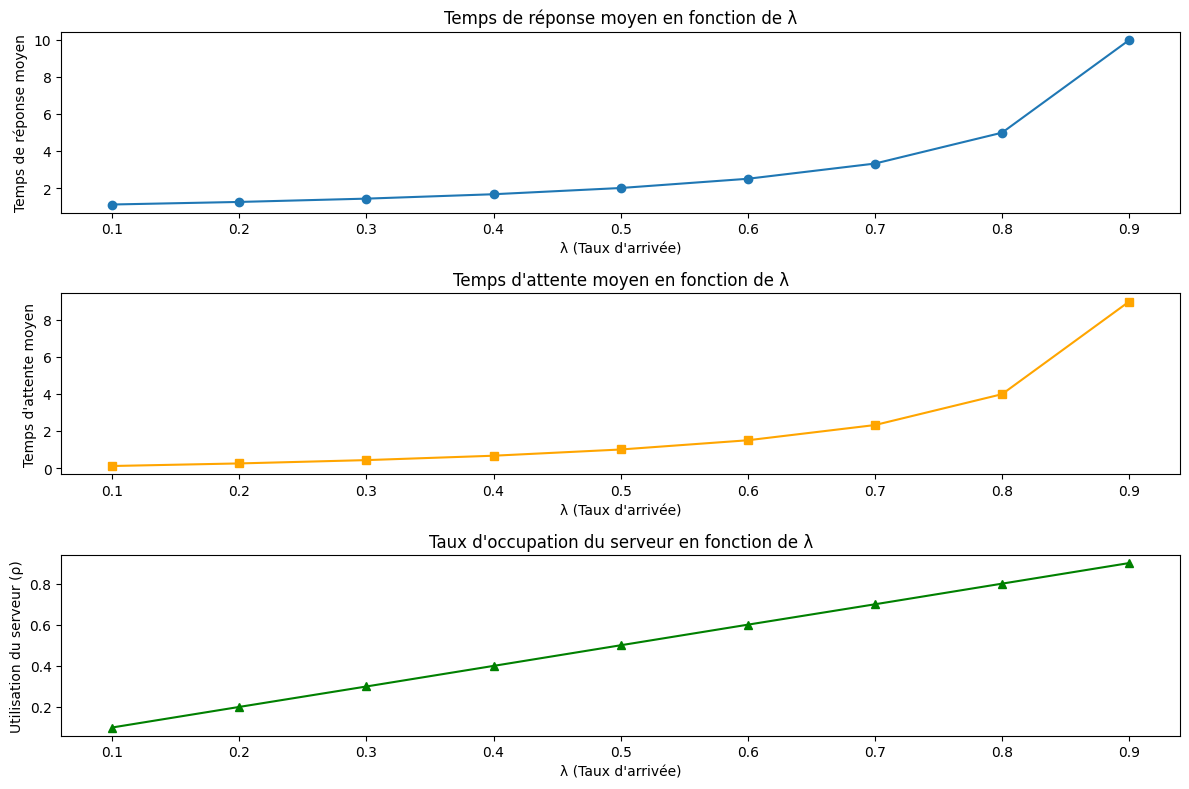

In [4]:
# Affichage des résultats sous forme de graphiques
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(results['lambda'], results['response_times'], marker='o')
plt.title('Temps de réponse moyen en fonction de λ')
plt.xlabel('λ (Taux d\'arrivée)')
plt.ylabel('Temps de réponse moyen')

plt.subplot(3, 1, 2)
plt.plot(results['lambda'], results['waiting_times'], marker='s', color='orange')
plt.title('Temps d\'attente moyen en fonction de λ')
plt.xlabel('λ (Taux d\'arrivée)')
plt.ylabel('Temps d\'attente moyen')

plt.subplot(3, 1, 3)
plt.plot(results['lambda'], results['utilization'], marker='^', color='green')
plt.title('Taux d\'occupation du serveur en fonction de λ')
plt.xlabel('λ (Taux d\'arrivée)')
plt.ylabel('Utilisation du serveur (ρ)')

plt.tight_layout()
plt.show()

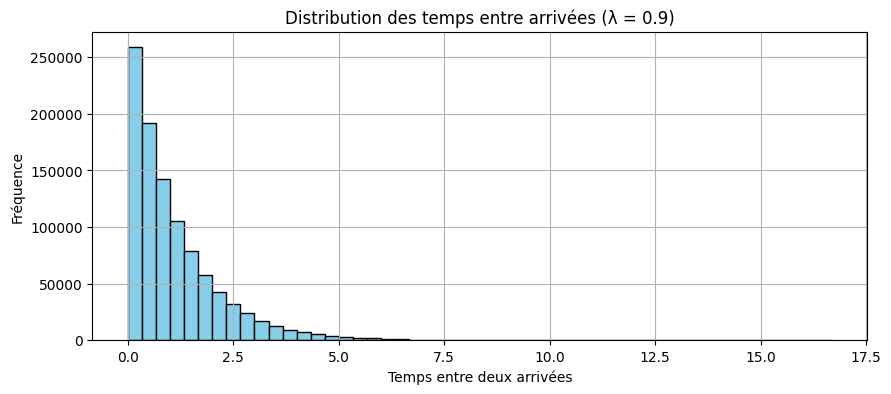

In [5]:
# Optional: Visualize inter-arrival times distribution for last experiment
inter_arrival_times = np.diff(queue.arrival_times)
plt.figure(figsize=(10, 4))
plt.hist(inter_arrival_times, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution des temps entre arrivées (λ = {:.1f})'.format(LAMBDA))
plt.xlabel('Temps entre deux arrivées')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()